In [1]:
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data.augmenters import NoAugmenter, EigenAugmenter, MyAugmenter
from src.data.patch_samplers import NoPatchSampler, EigenPatchSampler, MyPatchSampler
from src.data.kitti_raw import KITTIRAWDataset

from src.models import CoarseFine

In [2]:
kitti_path: str = '/media/antonio/523f31c5-dc82-4dce-8457-65b5dd1f19e4/kitti'

In [3]:
dataset = KITTIRAWDataset(
        NoAugmenter(),
        NoPatchSampler(),
        kitti_path,
        'train',
        'png',
)

In [4]:
model = CoarseFine()
checkpoint_path = os.path.join("experiments", "eigen","checkpoints","model_0.pth")
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

predicted depth map ranges in 2.86, 15443890798592.00
predicted depth map ranges in 3.51, 665214198480896.00
predicted depth map ranges in 3.77, 46925562773504.00


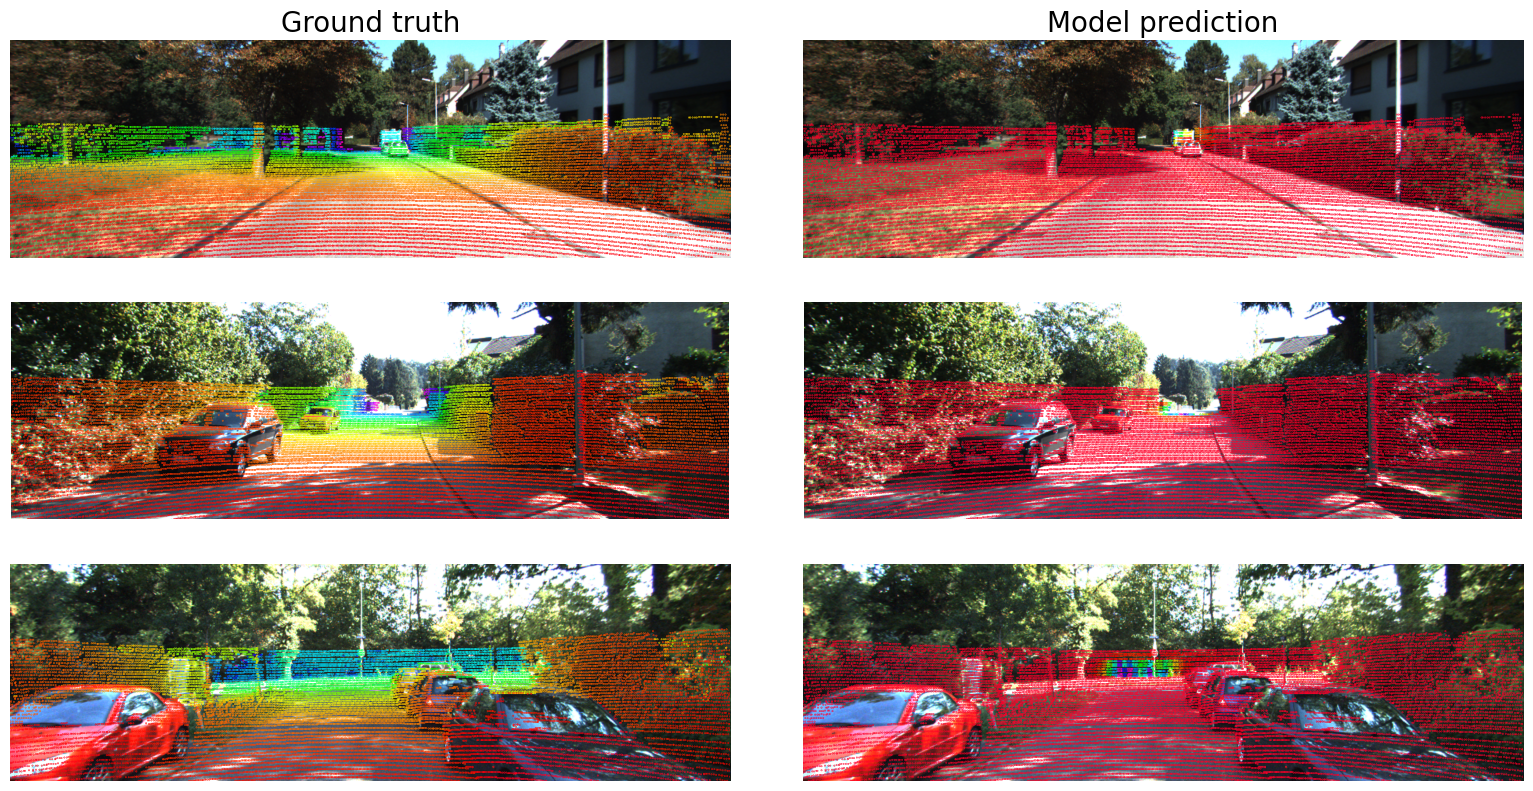

In [6]:
indices = random.choices(range(len(dataset)), k=6)
fig, axes = plt.subplots(3, 2, figsize=(16, 8))
plt.tight_layout()

axes[0, 0].set_title("Ground truth", fontsize=20)
axes[0, 1].set_title("Model prediction", fontsize=20)
for i in range(3):
    image, depth_map, camera_parameters = dataset[indices[i]]

    np_image = image[0].permute(1, 2, 0).numpy()
    np_depth_map = depth_map[0, 0].numpy()

    yy, xx = np.nonzero(np_depth_map)

    axes[i, 0].axis("off")
    axes[i, 0].imshow(np_image)
    axes[i, 0].scatter(xx, yy, c=np_depth_map[yy, xx], s=0.1, cmap="gist_rainbow")

    model.eval()
    with torch.no_grad():
        pred = model(image, camera_parameters)
    np_pred = pred[0, 0].numpy()
    print(f"predicted depth map ranges in {np_pred.min():.2f}, {np_pred.max():.2f}")

    axes[i, 1].axis("off")
    axes[i, 1].imshow(np_image)
    axes[i, 1].scatter(xx, yy, c=np_pred[yy, xx], s=0.1, cmap="gist_rainbow")

plt.show()